In [1]:
%pip install -r ../requirements.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import unicodedata
import spacy
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel



/home/carburauto/codes/uf/MLops/ai-text-recognition/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "../data/inter/train_drcat_"

In [4]:
drcat_01 = pd.read_csv(path + "01.csv")
drcat_02 = pd.read_csv(path + "02.csv")
drcat_03 = pd.read_csv(path + "03.csv")
drcat_04 = pd.read_csv(path + "04.csv")

In [5]:
drcat_01.head()

,text,label,source,fold
0,There are alot reasons to keep our the despise...,0,persuade_corpus,2
1,Driving smart cars that drive by themself has ...,0,persuade_corpus,4
2,"Dear Principal,\n\nI believe that students at ...",0,persuade_corpus,0
3,"Dear Principal,\n\nCommunity service should no...",0,persuade_corpus,0
4,My argument for the development of the driverl...,0,persuade_corpus,3


In [6]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.9 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
def remove_excessive_spaces(text: str) -> str:
    """
    This function removes excessive spaces from the text.

    Args:
        text (str): The input text.

    Returns:
        str: The text with excessive spaces removed.
    """
    return re.sub(r'\s+', ' ', text).strip() 

def remove_repeated_non_word_characters(text: str) -> str:
    """
    This function removes repeated non-word characters from the text.

    Args:
        text (str): The input text.

    Returns:
        str: The text with repeated non-word characters removed.
    """
    return re.sub(r'(\W)\1+', r'\1', text).strip()

def remove_first_line_from_text(text: str) -> str:
    """
    This function removes the first line from the text.

    Args:
        text (str): The input text.

    Returns:
        str: The text with the first line removed.
    """
    return re.sub(r'^.*\n', '', text).strip()

def remove_last_line_from_text(text: str) -> str:
    """
    This function removes the last line from the text.

    Args:
        text (str): The input text.

    Returns:
        str: The text with the last line removed.
    """
    return re.sub(r'\n.*$', '', text).strip()

def fix_isolated_commas_in_text(text: str) -> str:
    """
    This function fixes isolated commas in the text.

    Args:
        text (str): The input text.

    Returns:
        str: The text with isolated commas fixed.
    """
    text = re.sub(r' ([.,:;!?])', r'\1', text)
    return text.strip()

def keep_words_longer_than(text: str, min_length: int = 2) -> str:
    """
    This function keeps only the words in the text that are longer than a given length.

    Args:
        text (str): The input text.
        min_length (int, optional): The minimum length of the words to keep. Defaults to 2.

    Returns:
        str: The text with only the words longer than the given length.
    """
    return ' '.join([word for word in text.split() if len(word) > min_length])

def keep_only_alphabet_characters(text: str) -> str:
    """
    This function keeps only the alphabet characters in the text.

    Args:
        text (str): The input text.

    Returns:
        str: The text with only the alphabet characters.
    """
    return re.sub(r'[^a-zA-Z]', ' ', text).strip()

def remove_accents_from_text(text: str) -> str:
    """
    This function removes accents from the text.

    Args:
        text (str): The input text.

    Returns:
        str: The text with accents removed.
    """
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')

def lemmatize_text_with_spacy(text: str) -> str:
    """
    This function lemmatizes the text using the Spacy library.

    Args:
        text (str): The input text.

    Returns:
        str: The lemmatized text.
    """
    doc = nlp_spacy(text)
    return ' '.join([token.lemma_ for token in doc])


pipeline_clean_text = Pipeline([
    ('remove_first_line_from_text', FunctionTransformer(remove_first_line_from_text)),
    ('remove_last_line_from_text', FunctionTransformer(remove_last_line_from_text)),
    ('remove_excessive_spaces', FunctionTransformer(remove_excessive_spaces)),
    ('remove_repeated_non_word_characters', FunctionTransformer(remove_repeated_non_word_characters)),
    ('fix_isolated_commas_in_text', FunctionTransformer(fix_isolated_commas_in_text)),
])

nlp_spacy = spacy.load('en_core_web_sm')

In [8]:
drcat_01['clean_text'] = drcat_01['text'].apply(pipeline_clean_text.transform)
drcat_02['clean_text'] = drcat_02['text'].apply(pipeline_clean_text.transform)
drcat_03['clean_text'] = drcat_03['text'].apply(pipeline_clean_text.transform)
drcat_04['clean_text'] = drcat_04['text'].apply(pipeline_clean_text.transform)

In [9]:
df = pd.concat([drcat_01, drcat_02, drcat_03, drcat_04], axis=0, ignore_index=True)
df = df.drop(columns=['essay_id','source','fold'])
df = df.drop_duplicates()

In [10]:
df.columns

Index(['text', 'label', 'clean_text', 'prompt'], dtype='object')

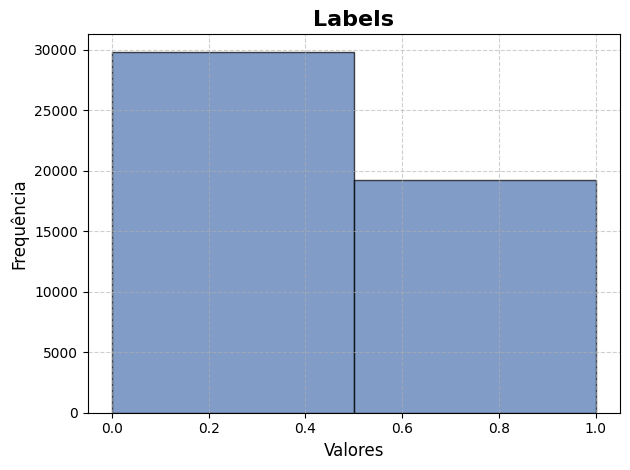

label
0    29792
1    19256
Name: count, dtype: int64


In [11]:
plt.hist(df['label'], bins=2, color='#4c72b0', edgecolor='black', alpha=0.7)
plt.title('Labels', fontsize=16, fontweight='bold')
plt.xlabel('Valores', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(df['label'].value_counts())

In [12]:
counts = df['label'].value_counts()
print("Contagem original dos rótulos:")
print(counts)

min_label_count = counts.min()

df_minority = df[df['label'] == counts.idxmin()]
df_majority = df[df['label'] == counts.idxmax()]


df_majority_balanced = df_majority.sample(n=min_label_count, random_state=42)


df_balanced = pd.concat([df_minority, df_majority_balanced], axis=0)

print("\nContagem balanceada dos rótulos:")
print(df_balanced['label'].value_counts())

Contagem original dos rótulos:
label
0    29792
1    19256
Name: count, dtype: int64

Contagem balanceada dos rótulos:
label
1    19256
0    19256
Name: count, dtype: int64


In [13]:
df_balanced.to_csv('../data/preprocessed/balanced.csv', index=False)

In [14]:
model_name = "bert-base-uncased"  # Modelo BERT pré-treinado
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

def generate_embeddings(texts, tokenizer, model, device):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # O CLS token está na posição 0
        embeddings.append(cls_embedding.cpu().numpy())
    
    # Concatenar todos os embeddings em um array
    return torch.cat(embeddings).numpy()

# Aplicar a função ao DataFrame
df_balanced['embeddings'] = generate_embeddings(df_balanced['clean_text'], tokenizer, model, device)

# Exibir os resultados
print(df_balanced[['clean_text', 'embeddings']])


KeyboardInterrupt: 

In [15]:
df_balanced.to_csv('../data/preprocessed/df_embedded.csv')

### Weights and bias

In [17]:
import wandb

import params

In [18]:
!wandb login

wandb: Currently logged in as: pedro_miguel (pedro_miguel-universidade-federal-do-rio-grande-do-norte). Use `wandb login --relogin` to force relogin


In [19]:
wandb.init(project=params.WANDB_PROJECT)

wandb: Currently logged in as: pedro_miguel (pedro_miguel-universidade-federal-do-rio-grande-do-norte). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [20]:
external_raw_data_artifact = wandb.Artifact("daigt_proper_train_dataset", type="raw")
external_dataset_artifact = wandb.Artifact("drcat_data", type="dataset")

In [21]:
external_raw_data_artifact.add_file('../data/raw/daigt-proper-train-dataset.zip')

for i in range(1, 5):
    external_dataset_artifact.add_file(f'../data/inter/train_drcat_0{i}.csv')

ValueError: Path is not a file: '../data/raw/daigt-proper-train-dataset.zip'

In [ ]:
wandb.log_artifact(external_raw_data_artifact)
wandb.log_artifact(external_dataset_artifact)

In [ ]:
table = wandb.Table(dataframe=df)
wandb.log({"Cleaned and merged data": table})

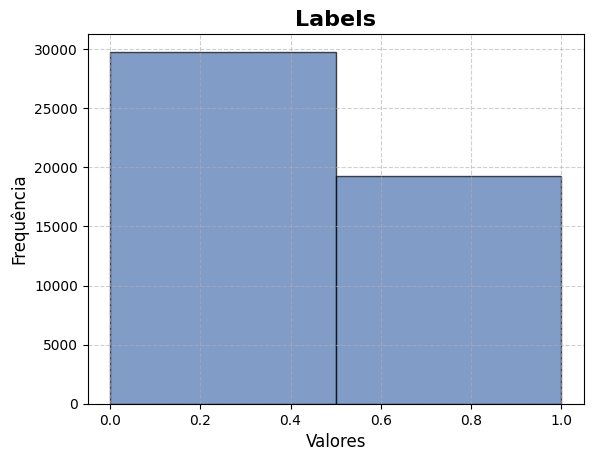

In [19]:
data = {'Generated': 1375, 'Not Generated': 3}

fig, ax = plt.subplots()
plt.hist(df['label'], bins=2, color='#4c72b0', edgecolor='black', alpha=0.7)
ax.set_title('Labels', fontsize=16, fontweight='bold')
ax.set_xlabel('Valores', fontsize=12)
ax.set_ylabel('Frequência', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

wandb.log({"Merged data distribution": wandb.Image(fig)})

In [20]:
wandb.log({
    "Balanced data distribuition": wandb.Html("""
        <h3>Merged banlanced data set analysis</h3>
        <p> After the preprocessing, merging and the dropping of random samples of the dataset, it is
        <strong>balanced an ready to be used for training the model,</strong> each label has now 19256 samples.
        Next step is the model building</p>     
""")
})

In [21]:
balanced_data_artifact = wandb.Artifact("balanced_data", type="dataset")
balanced_data_artifact.add_file("../data/preprocessed/balanced.csv")

wandb.log_artifact(balanced_data_artifact)

<Artifact balanced_data>

In [22]:
embedded_data_artifact = wandb.Artifact("embedded_df", type="dataset")
embedded_data_artifact.add_file("../data/preprocessed/embedded.csv")

wandb.log_artifact(embedded_data_artifact)

<Artifact embedded_df>

In [23]:
wandb.finish()